In [1]:
import ray
import sys

sys.path.append("..")

In [2]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2024-02-13 11:15:13,970	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.13
Ray version:,2.9.2
Dashboard:,http://127.0.0.1:8265


In [3]:
ray.cluster_resources()

{'object_store_memory': 8160347750.0,
 'node:172.30.66.101': 1.0,
 'node:__internal_head__': 1.0,
 'memory': 16320695502.0,
 'CPU': 28.0,
 'GPU': 1.0,
 'accelerator_type:G': 1.0}

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

plt.rcParams["figure.dpi"] = 300
sns.set_theme(style="whitegrid")

In [5]:
data_path = Path("../data/cafa5")

In [6]:
df = pd.read_parquet(data_path / "train_bp_top500_seqs.parquet")
print(df.shape)
df.head()

(92210, 3)


,Entry ID,Sequence,Index
0,A0A009IHW8,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,0
1,A0A021WW32,MFYEHIILAKKGPLARIWLAAHWDKKITKAHVFETNIEKSVEGILQ...,1
2,A0A023FFD0,MHSTIVYACLLALAVFVALHGTPLAALAENGEGTTQPDYDNSTDYY...,2
3,A0A023GPJ3,MDRDAEEGRPLSLVNRRPSISAPISGRKSAPASAAAAVAAAAAAAA...,3
4,A0A023GPK8,MSTIKLLIIGQLWLSIGLISGDDSLDTREGVDLVLKCRFTEHYDST...,4


## 🍲 Data

#### 🔍 EDA

In [7]:
seq_lens = df["Sequence"].str.len()
print(f"Sequence length min: {seq_lens.min()}, max: {seq_lens.max()}")

Sequence length min: 3, max: 35375


In [8]:
# the sequence of length 3
seq_lens.loc[seq_lens == 3]

# it's a peptide: https://www.uniprot.org/uniprotkb/P84761

41900    3
Name: Sequence, dtype: int64

[Text(0.5, 0, 'Sequence Length')]

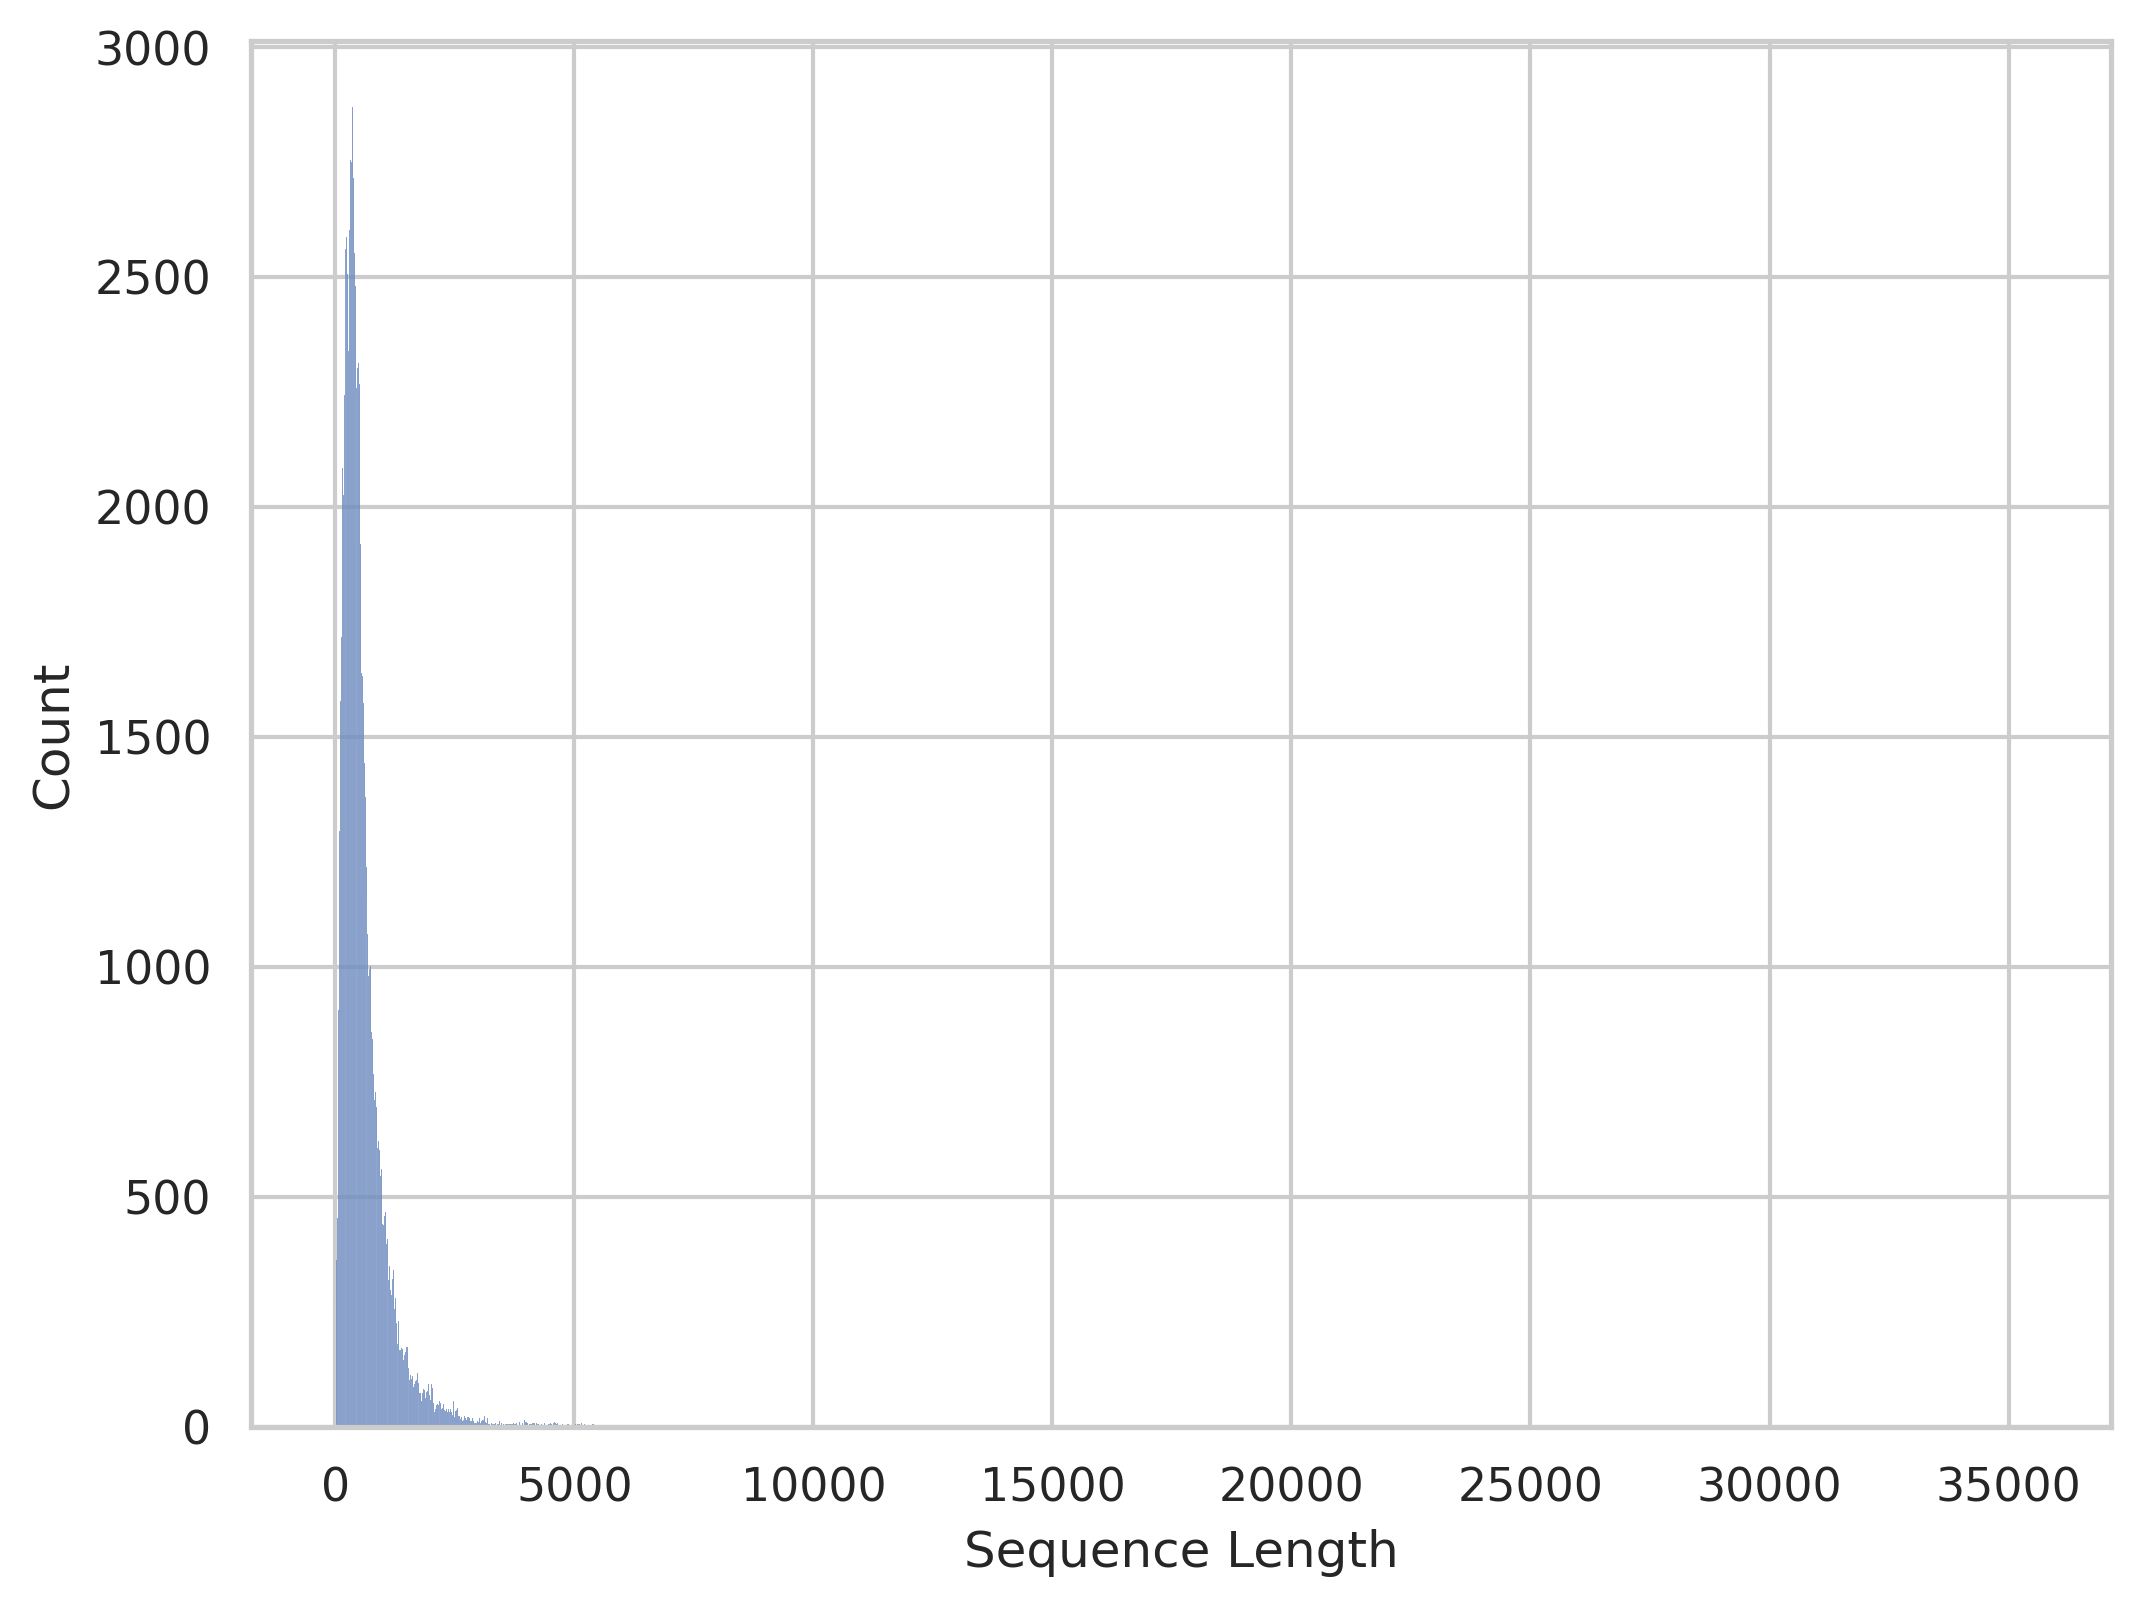

In [9]:
# chain length distribution
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax = sns.histplot(data=seq_lens, ax=ax)
ax.set(xlabel="Sequence Length")

#### ✂️ Split Data

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
test_size = 0.2
train_df, test_df = train_test_split(df, test_size=test_size, random_state=0)
train_df.head()

,Entry ID,Sequence,Index
16668,G3UZY9,KNSPKEFTASESEVCIKTFKEQMRLELELPKLPGNRPTSPKISPRS...,16668
63730,Q7T3S3,MKQTILDLMRMSRICRMVLATCLGSFILVIFYFQSMFQPVMRRNPF...,63730
27915,P0AEC8,MRHSLPYRMLRKRPMKLSTTVILMVSAVLFSVLLVVHLIYFSQISD...,27915
80016,Q9HY46,MRRTKEDSEKTRTAILLAAEELFLEKGVSHTSLEQIARAAGVTRGA...,80016
1959,A0A0R4IRU1,RLLSRMAGMKDQQFTEEKPLLPDSRGQETEMENCETFVATGDWKEH...,1959


In [12]:
train_df.to_parquet(data_path / "train_split.parquet")
test_df.to_parquet(data_path / "test_split.parquet")

In [13]:
# further split a validation set
valid_size = 0.25  # 0.8*0.25=0.2
train_df, valid_df = train_test_split(train_df, test_size=valid_size, random_state=0)

#### 🏭 Data Processing

In [14]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, EsmModel

In [15]:
# targets
targets = np.load(data_path / "train_bp_top500_targets.npy")
targets.shape

(92210, 500)

In [16]:
model_name = "facebook/esm2_t12_35M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [17]:
seq = df["Sequence"].iloc[0]
len(seq)

269

In [18]:
seq

'MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENARIQSKLSDLQKKKIDIDNKLLKEKQNLIKEEILERKKLEVLTKKQQKDEIEHQKKLKREIDAIKASTQYITDVSISSYNNTIPETEPEYDLFISHASEDKEDFVRPLAETLQQLGVNVWYDEFTLKVGDSLRQKIDSGLRNSKYGTVVLSTDFIKKDWTNYELDGLVAREMNGHKMILPIWHKITKNDVLDYSPNLADKVALNTSVNSIEEIAHQLADVILNR'

In [19]:
encoded_seq = tokenizer([seq], padding=False, truncation=True, return_tensors="np")
encoded_seq["input_ids"]

array([[ 0, 20,  8,  4,  9, 16, 15, 15,  6,  5, 13, 12, 12,  8, 15, 12,
         4, 16, 12, 16, 17,  8, 12,  6, 15, 11, 11,  8, 14,  8, 11,  4,
        15, 11, 15,  4,  8,  9, 12,  8, 10, 15,  9, 16,  9, 17,  5, 10,
        12, 16,  8, 15,  4,  8, 13,  4, 16, 15, 15, 15, 12, 13, 12, 13,
        17, 15,  4,  4, 15,  9, 15, 16, 17,  4, 12, 15,  9,  9, 12,  4,
         9, 10, 15, 15,  4,  9,  7,  4, 11, 15, 15, 16, 16, 15, 13,  9,
        12,  9, 21, 16, 15, 15,  4, 15, 10,  9, 12, 13,  5, 12, 15,  5,
         8, 11, 16, 19, 12, 11, 13,  7,  8, 12,  8,  8, 19, 17, 17, 11,
        12, 14,  9, 11,  9, 14,  9, 19, 13,  4, 18, 12,  8, 21,  5,  8,
         9, 13, 15,  9, 13, 18,  7, 10, 14,  4,  5,  9, 11,  4, 16, 16,
         4,  6,  7, 17,  7, 22, 19, 13,  9, 18, 11,  4, 15,  7,  6, 13,
         8,  4, 10, 16, 15, 12, 13,  8,  6,  4, 10, 17,  8, 15, 19,  6,
        11,  7,  7,  4,  8, 11, 13, 18, 12, 15, 15, 13, 22, 11, 17, 19,
         9,  4, 13,  6,  4,  7,  5, 10,  9, 20, 17,  6, 21, 15, 

In [20]:
tokenizer.decode(encoded_seq["input_ids"][0])

'<cls> M S L E Q K K G A D I I S K I L Q I Q N S I G K T T S P S T L K T K L S E I S R K E Q E N A R I Q S K L S D L Q K K K I D I D N K L L K E K Q N L I K E E I L E R K K L E V L T K K Q Q K D E I E H Q K K L K R E I D A I K A S T Q Y I T D V S I S S Y N N T I P E T E P E Y D L F I S H A S E D K E D F V R P L A E T L Q Q L G V N V W Y D E F T L K V G D S L R Q K I D S G L R N S K Y G T V V L S T D F I K K D W T N Y E L D G L V A R E M N G H K M I L P I W H K I T K N D V L D Y S P N L A D K V A L N T S V N S I E E I A H Q L A D V I L N R <eos>'

In [21]:
def tokenize_seqs(batch, targets, tokenizer, padding=False, truncation=True):
    encoded_seqs = tokenizer(
        batch["Sequence"].tolist(),
        padding=padding,
        truncation=truncation,
        return_tensors="np",
    )
    return dict(
        input_ids=encoded_seqs["input_ids"],
        attention_mask=encoded_seqs["attention_mask"],
        targets=targets[batch["Index"].tolist()],
    )

In [22]:
def preprocess(
    df,
    targets,
    tokenizer,
):
    return tokenize_seqs(
        df,
        targets,
        tokenizer,
    )

In [23]:
preprocess(train_df, targets, tokenizer)

{'input_ids': array([array([ 0, 20, 17,  4,  4, 11,  8,  7,  7,  4,  6,  4, 23, 23, 11,  7,  8,
                5, 16, 11,  7,  8,  6,  8,  9,  9, 15,  6,  4, 12, 10, 14, 18, 12,
                4, 13,  5, 12, 16,  9,  5, 15, 10,  4,  7, 13, 13,  8, 19,  4, 19,
                8, 10, 10, 11,  8,  4,  9, 10,  7, 10, 15, 17, 13, 19, 12, 15, 14,
                8, 13,  7,  4, 10,  4, 20, 15, 16, 14, 15, 10, 15,  5, 10,  9,  5,
                7, 10,  5,  5, 13, 19,  4,  9, 16, 11,  4, 10, 12, 12,  8,  9, 15,
               11, 21, 21,  5, 21, 15, 10,  8, 12, 17,  5, 11,  5,  4,  4,  8, 21,
                9,  9,  4, 10, 11, 12,  9, 13,  7, 11,  6, 23,  5,  6, 16, 11,  4,
               14, 14, 14, 23, 10, 11,  4, 14, 13,  4, 17, 10, 19, 10, 11,  5, 17,
                8,  7, 23, 17, 17, 21, 12, 17, 14,  4, 16,  6,  5,  8, 17, 11,  5,
               18, 11, 10, 22,  4, 14, 14,  7, 19,  9, 13, 17,  7,  8,  9, 14, 10,
                6, 22, 17, 14,  9, 10,  4, 19, 17,  6,  5,  5,  4, 14,  4,

#### ☁️ Distributed Processing

In [24]:
ray.data.DatasetContext.get_current().execution_options.preserve_order = (
    True  # deterministic
)

In [25]:
ds = ray.data.read_parquet(data_path / "train_split.parquet")
ds = ds.random_shuffle(seed=0)
ds.take(1)

Parquet Files Sample 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-02-13 11:15:45,841	INFO dataset.py:2488 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-02-13 11:15:45,844	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=89 for stage ReadParquet to satisfy output blocks of size at least DataContext.get_current().target_min_block_size=1.0MiB.
2024-02-13 11:15:45,845	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 89, each read task output is split into 89 smaller blocks.
2024-02-13 11:15:45,845	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle] -> LimitOperator[limit=1]
2024-02-13 11:15:45,846	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, prese

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(ReadParquet->SplitBlocks(89) pid=54098) /home/ytian/anaconda3/envs/ml/lib/python3.10/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by mode='default'.
(ReadParquet->SplitBlocks(89) pid=54098)   return transform_pyarrow.concat(tables)


[{'Entry ID': 'Q17604',
  'Sequence': 'MVSHKKNDRPRPLWILKIHKRLSLFEFKRYATGIGKDDGQDISWVLKGNAKNNVYQVTVETMENCETDECKKVIWVPDELAESTGTMFEDFKEDQPQESVSSISNNEANWGSSVNELDENYEKMQKEETFDPYDSDSDTSEDSDFDEDFEDSDKTMCSGQS',
  'Index': 48142,
  '__index_level_0__': 48142}]

In [26]:
test_size = 0.25
train_ds, valid_ds = ds.train_test_split(test_size=test_size)

2024-02-13 11:15:46,979	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=89 for stage ReadParquet to satisfy output blocks of size at least DataContext.get_current().target_min_block_size=1.0MiB.
2024-02-13 11:15:46,979	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 89, each read task output is split into 89 smaller blocks.
2024-02-13 11:15:46,980	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle]
2024-02-13 11:15:46,980	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-13 11:15:46,981	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
sample_ds = train_ds.map_batches(
    preprocess,
    fn_kwargs={
        "tokenizer": tokenizer,
        "targets": targets,
    },
    batch_format="pandas",
)
sample_ds.show(1)

2024-02-13 11:15:47,622	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=1]
2024-02-13 11:15:47,623	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-13 11:15:47,623	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/67 [00:00<?, ?it/s]

{'input_ids': array([ 0, 20,  7,  8, 21, 15, 15, 17, 13, 10, 14, 10, 14,  4, 22, 12,  4,
       15, 12, 21, 15, 10,  4,  8,  4, 18,  9, 18, 15, 10, 19,  5, 11,  6,
       12,  6, 15, 13, 13,  6, 16, 13, 12,  8, 22,  7,  4, 15,  6, 17,  5,
       15, 17, 17,  7, 19, 16,  7, 11,  7,  9, 11, 20,  9, 17, 23,  9, 11,
       13,  9, 23, 15, 15,  7, 12, 22,  7, 14, 13,  9,  4,  5,  9,  8, 11,
        6, 11, 20, 18,  9, 13, 18, 15,  9, 13, 16, 14, 16,  9,  8,  7,  8,
        8, 12,  8, 17, 17,  9,  5, 17, 22,  6,  8,  8,  7, 17,  9,  4, 13,
        9, 17, 19,  9, 15, 20, 16, 15,  9,  9, 11, 18, 13, 14, 19, 13,  8,
       13,  8, 13, 11,  8,  9, 13,  8, 13, 18, 13,  9, 13, 18,  9, 13,  8,
       13, 15, 11, 20, 23,  8,  6, 16,  8,  2]), 'attention_mask': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 

## 🏃Training

In [28]:
import os
import json
import random

In [29]:
def set_seeds(seed=0):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    eval("setattr(torch.backends.cudnn, 'deterministic', True)")
    eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    os.environ["PYTHONHASHSEED"] = str(seed)

In [30]:
DATASET_LOC = data_path / "train_split.parquet"


def load_data(num_samples=None):
    ds = ray.data.read_parquet(DATASET_LOC)
    ds = ds.random_shuffle(seed=0)
    ds = ray.data.from_items(ds.take(num_samples)) if num_samples else ds
    return ds

In [31]:
class CustomPreprocessor:
    """Custom preprocessor class."""

    def transform(self, ds):
        return ds.map_batches(
            preprocess,
            fn_kwargs={
                "tokenizer": tokenizer,
                "targets": targets,
            },
            batch_format="pandas",
        )

#### 🤖 Model

In [32]:
llm = EsmModel.from_pretrained(model_name)
embedding_dim = llm.config.hidden_size
embedding_dim

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


480

In [33]:
pad_token_id = llm.config.pad_token_id
pad_token_id

1

In [34]:
# sample
batch = tokenizer([seq[:10], seq[10:30]], return_tensors="pt", padding="longest")
outputs = llm(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
outputs

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.1446, -0.2660,  0.1712,  ..., -0.4816, -0.0534,  0.1805],
         [-0.5734, -0.0414,  0.0484,  ..., -0.3091, -0.1884,  0.1087],
         [-0.1941,  0.1439,  0.3154,  ...,  0.0504, -0.3529,  0.2344],
         ...,
         [-0.1977, -0.1326,  0.2912,  ..., -0.1406, -0.1176,  0.0924],
         [-0.1192, -0.0658,  0.2952,  ..., -0.0859, -0.1602,  0.1112],
         [-0.1797,  0.0206,  0.2692,  ..., -0.1254, -0.2582,  0.0178]],

        [[-0.2242, -0.1906,  0.1815,  ..., -0.6006, -0.0007,  0.1336],
         [-0.3523,  0.1899, -0.0292,  ..., -0.4881, -0.0595,  0.0969],
         [-0.1907,  0.1744,  0.2269,  ..., -0.3823, -0.0320,  0.1509],
         ...,
         [-0.1719,  0.2291,  0.2042,  ..., -0.2456, -0.3433,  0.0727],
         [ 0.0536, -0.1797,  0.2266,  ..., -0.2682, -0.1334, -0.0527],
         [-0.3323,  0.2857,  0.2473,  ..., -0.5516, -0.1463,  0.0068]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_ou

In [35]:
last_hidden_state, pool = outputs.last_hidden_state, outputs.pooler_output
last_hidden_state.shape, pool.shape

(torch.Size([2, 22, 480]), torch.Size([2, 480]))

In [36]:
# mean pooling of last_hidden_state

# first expand the mask
mask = batch["attention_mask"].unsqueeze(-1).expand(last_hidden_state.shape).float()

# sum unmasked token embeddings
sum_embeddings = torch.sum(last_hidden_state * mask, dim=1)

# number of unmasked tokens for each sequence
# set a min value to avoid divide by zero
num_tokens = torch.clamp(mask.sum(1), min=1e-9)

# divide
mean_embeddings = sum_embeddings / num_tokens
mean_embeddings.shape

torch.Size([2, 480])

In [37]:
# from transformers import AutoModelForSequenceClassification

# model = AutoModelForSequenceClassification.from_pretrained(
#     "distilbert-base-uncased", num_labels=2
# )
# model

In [38]:
class FinetunedESM(nn.Module):
    def __init__(self, llm, dropout_p, embedding_dim, num_classes):
        super().__init__()
        self.llm = llm
        self.dropout_p = dropout_p
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.dropout = nn.Dropout(dropout_p)
        self.pre_classifier = nn.Linear(embedding_dim, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def mean_pooling(self, token_embeddings, attention_mask):
        """Average the embedding of all amino acids in a sequence"""

        # expand the mask
        expanded_mask = (
            attention_mask.unsqueeze(-1).expand(token_embeddings.shape).float()
        )

        # sum unmasked token embeddings
        sum_embeddings = torch.sum(token_embeddings * expanded_mask, dim=1)

        # number of unmasked tokens for each sequence
        # set a min value to avoid divide by zero
        num_tokens = torch.clamp(expanded_mask.sum(1), min=1e-9)

        # divide
        mean_embeddings = sum_embeddings / num_tokens
        return mean_embeddings

    def forward(self, batch):
        input_ids, attention_mask = batch["input_ids"], batch["attention_mask"]

        # per token representations from the last layer
        token_embeddings = self.llm(
            input_ids=input_ids, attention_mask=attention_mask
        ).last_hidden_state

        # average per token representations
        mean_embeddings = self.mean_pooling(token_embeddings, attention_mask)

        # https://github.com/huggingface/transformers/blob/main/src/transformers/models/distilbert/modeling_distilbert.py
        mean_embeddings = self.pre_classifier(mean_embeddings)  # (bs, embedding_dim)
        mean_embeddings = nn.ReLU()(mean_embeddings)
        mean_embeddings = self.dropout(mean_embeddings)

        logits = self.classifier(mean_embeddings)  # (bs, num_classes)
        return logits

    @torch.inference_mode()
    def predict(self, batch):
        self.eval()
        y = self(batch)
        return y.cpu().numpy()

    def save(self, dp):
        with open(Path(dp, "args.json"), "w") as fp:
            contents = {
                "dropout_p": self.dropout_p,
                "embedding_dim": self.embedding_dim,
                "num_classes": self.num_classes,
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

        torch.save(self.state_dict(), Path(dp) / "model.pt")

    @classmethod
    def load(cls, esm_model, args_fp, state_dict_fp):
        with open(args_fp, "r") as fp:
            kwargs = json.load(fp=fp)

        llm = EsmModel.from_pretrained(esm_model)
        model = cls(llm=llm, **kwargs)
        model.load_state_dict(
            torch.load(state_dict_fp, map_location=torch.device("cpu"))
        )
        return model

In [39]:
model = FinetunedESM(
    llm=llm, dropout_p=0.1, embedding_dim=embedding_dim, num_classes=500
)
print(model.parameters)

<bound method Module.parameters of FinetunedESM(
  (llm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 480, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 480, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-11): 12 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=480, out_features=480, bias=True)
              (key): Linear(in_features=480, out_features=480, bias=True)
              (value): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=480, out_features=480, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNo

In [40]:
from ray.train.torch import get_device

get_device()

device(type='cuda', index=0)

In [41]:
def pad_array(arr, dtype=np.int32):
    max_len = max(len(row) for row in arr)
    padded_arr = np.zeros((arr.shape[0], max_len), dtype=dtype)
    for i, row in enumerate(arr):
        padded_arr[i][: len(row)] = row
    return padded_arr

In [42]:
def collate_fn(batch):
    batch["input_ids"] = pad_array(batch["input_ids"])
    batch["attention_mask"] = pad_array(batch["attention_mask"])
    dtypes = {
        "input_ids": torch.int32,
        "attention_mask": torch.int32,
        "targets": torch.float,
    }
    tensor_batch = {}
    for key, array in batch.items():
        tensor_batch[key] = torch.as_tensor(
            array.copy(), dtype=dtypes[key], device=get_device()
        )
    return tensor_batch

In [43]:
sample_batch = sample_ds.take_batch(batch_size=8)
sample_batch

2024-02-13 11:15:50,865	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)] -> LimitOperator[limit=8]
2024-02-13 11:15:50,865	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-13 11:15:50,866	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/67 [00:00<?, ?it/s]

{'input_ids': array([array([ 0, 20,  7,  8, 21, 15, 15, 17, 13, 10, 14, 10, 14,  4, 22, 12,  4,
               15, 12, 21, 15, 10,  4,  8,  4, 18,  9, 18, 15, 10, 19,  5, 11,  6,
               12,  6, 15, 13, 13,  6, 16, 13, 12,  8, 22,  7,  4, 15,  6, 17,  5,
               15, 17, 17,  7, 19, 16,  7, 11,  7,  9, 11, 20,  9, 17, 23,  9, 11,
               13,  9, 23, 15, 15,  7, 12, 22,  7, 14, 13,  9,  4,  5,  9,  8, 11,
                6, 11, 20, 18,  9, 13, 18, 15,  9, 13, 16, 14, 16,  9,  8,  7,  8,
                8, 12,  8, 17, 17,  9,  5, 17, 22,  6,  8,  8,  7, 17,  9,  4, 13,
                9, 17, 19,  9, 15, 20, 16, 15,  9,  9, 11, 18, 13, 14, 19, 13,  8,
               13,  8, 13, 11,  8,  9, 13,  8, 13, 18, 13,  9, 13, 18,  9, 13,  8,
               13, 15, 11, 20, 23,  8,  6, 16,  8,  2])                           ,
        array([ 0, 20,  5, 11, 19,  8,  4,  5, 17,  9, 10,  4, 10,  5,  4,  9, 13,
               12,  9, 10,  9, 12,  6,  5, 12,  4, 16, 17,  5,  6, 11,  5

In [44]:
sample_batch = collate_fn(batch=sample_batch)
sample_batch

{'input_ids': tensor([[ 0, 20,  7,  ...,  0,  0,  0],
         [ 0, 20,  5,  ...,  0,  0,  0],
         [ 0, 20, 16,  ...,  9,  8,  2],
         ...,
         [ 0, 20,  5,  ...,  0,  0,  0],
         [ 0, 20, 17,  ...,  0,  0,  0],
         [ 0, 20,  8,  ...,  0,  0,  0]], device='cuda:0', dtype=torch.int32),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0', dtype=torch.int32),
 'targets': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]], device='cuda:0')}

In [45]:
sample_batch["targets"].shape

torch.Size([8, 500])

In [46]:
import ray.train as train
from ray.train import Checkpoint, CheckpointConfig, DataConfig, RunConfig, ScalingConfig
from ray.train.torch import TorchCheckpoint, TorchTrainer
import tempfile
import torch.nn.functional as F
from torch.nn.parallel.distributed import DistributedDataParallel

In [47]:
model.to(get_device())
sample_output = model(sample_batch)
sample_output.shape

torch.Size([8, 500])

In [48]:
def train_step(ds, batch_size, model, num_classes, loss_fn, optimizer):
    model.train()
    train_loss = []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    for batch in ds_generator:
        optimizer.zero_grad()
        y_hat = model(batch)
        if num_classes == 1:
            y_hat = y_hat.unsqueeze(1)
        loss = loss_fn(y_hat, batch["targets"])
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    return np.mean(train_loss)

In [49]:
def eval_step(ds, batch_size, model, num_classes, loss_fn):
    model.eval()
    eval_loss = []
    y_trues, y_preds = [], []
    ds_generator = ds.iter_torch_batches(batch_size=batch_size, collate_fn=collate_fn)
    with torch.no_grad():
        for batch in ds_generator:
            y_hat = model(batch)
            if num_classes == 1:
                y_hat = y_hat.unsqueeze(1)
            loss = loss_fn(y_hat, batch["targets"])
            eval_loss.append(loss.item())
            y_trues.extend(batch["targets"].cpu().numpy())
            y_preds.extend(y_hat.cpu().numpy())

    return np.mean(eval_loss), y_trues, y_preds

In [50]:
def train_loop_per_worker(config):
    # Hyperparameters
    esm_model = config["esm_model"]
    dropout_p = config["dropout_p"]
    lr = config["lr"]
    lr_factor = config["lr_factor"]
    lr_patience = config["lr_patience"]
    num_epochs = config["num_epochs"]
    batch_size = config["batch_size"]
    num_classes = config["num_classes"]

    set_seeds()
    train_ds = train.get_dataset_shard("train")
    val_ds = train.get_dataset_shard("val")

    llm = EsmModel.from_pretrained(esm_model)
    model = FinetunedESM(
        llm=llm,
        dropout_p=dropout_p,
        embedding_dim=llm.config.hidden_size,
        num_classes=num_classes,
    )
    model = train.torch.prepare_model(model)

    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer, mode="min", factor=lr_factor, patience=lr_patience
    )

    num_workers = train.get_context().get_world_size()
    batch_size_per_worker = batch_size // num_workers

    for epoch in range(num_epochs):
        train_loss = train_step(
            train_ds, batch_size_per_worker, model, num_classes, loss_fn, optimizer
        )
        val_loss, _, _ = eval_step(
            val_ds, batch_size_per_worker, model, num_classes, loss_fn
        )
        scheduler.step(val_loss)

        # Checkpoint
        with tempfile.TemporaryDirectory(prefix="ray_results") as dp:
            if isinstance(model, DistributedDataParallel):  # cpu
                model.module.save(dp=dp)
            else:
                model.save(dp=dp)
            metrics = dict(
                epoch=epoch,
                lr=optimizer.param_groups[0]["lr"],
                train_loss=train_loss,
                val_loss=val_loss,
            )
            checkpoint = Checkpoint.from_directory(dp)
            train.report(metrics, checkpoint=checkpoint)

In [51]:
# Train loop config
train_loop_config = {
    "esm_model": model_name,
    "dropout_p": 0.1,
    "lr": 1e-3,
    "lr_factor": 0.8,
    "lr_patience": 3,
    "num_epochs": 5,
    "batch_size": 8,
    "num_classes": 500,
}

In [52]:
# Scaling config
num_workers = 1
resources_per_worker = {"CPU": 16, "GPU": 1}

scaling_config = ScalingConfig(
    num_workers=num_workers,
    use_gpu=bool(resources_per_worker["GPU"]),
    resources_per_worker=resources_per_worker,
)

In [53]:
# Run config
checkpoint_config = CheckpointConfig(
    num_to_keep=1, checkpoint_score_attribute="val_loss", checkpoint_score_order="min"
)
run_config = RunConfig(
    name="llm",
    checkpoint_config=checkpoint_config,
    storage_path=str(Path().resolve() / "ray_results"),
)

In [54]:
ds = load_data()
test_size = 0.25
train_ds, valid_ds = ds.train_test_split(test_size=test_size)

Parquet Files Sample 0:   0%|          | 0/1 [00:00<?, ?it/s]

2024-02-13 11:15:52,852	INFO set_read_parallelism.py:115 -- Using autodetected parallelism=89 for stage ReadParquet to satisfy output blocks of size at least DataContext.get_current().target_min_block_size=1.0MiB.
2024-02-13 11:15:52,852	INFO set_read_parallelism.py:122 -- To satisfy the requested parallelism of 89, each read task output is split into 89 smaller blocks.
2024-02-13 11:15:52,853	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadParquet] -> AllToAllOperator[RandomShuffle]
2024-02-13 11:15:52,853	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-13 11:15:52,853	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data

- RandomShuffle 1:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Map 2:   0%|          | 0/1 [00:00<?, ?it/s]

Shuffle Reduce 3:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

(ReadParquet->SplitBlocks(89) pid=54075) /home/ytian/anaconda3/envs/ml/lib/python3.10/site-packages/ray/data/_internal/arrow_block.py:148: FutureWarning: promote has been superseded by mode='default'.
(ReadParquet->SplitBlocks(89) pid=54075)   return transform_pyarrow.concat(tables)


In [55]:
preprocessor = CustomPreprocessor()
train_ds = preprocessor.transform(train_ds)
val_ds = preprocessor.transform(valid_ds)
train_ds = train_ds.materialize()
valid_ds = val_ds.materialize()

2024-02-13 11:15:53,381	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-02-13 11:15:53,382	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-13 11:15:53,382	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/67 [00:00<?, ?it/s]

2024-02-13 11:15:55,366	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)]
2024-02-13 11:15:55,367	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
2024-02-13 11:15:55,367	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/23 [00:00<?, ?it/s]

In [56]:
options = ray.data.ExecutionOptions(preserve_order=True)
dataset_config = DataConfig(datasets_to_split=["train"], execution_options=options)

In [57]:
# Trainer
trainer = TorchTrainer(
    train_loop_per_worker=train_loop_per_worker,
    train_loop_config=train_loop_config,
    scaling_config=scaling_config,
    run_config=run_config,
    datasets={"train": train_ds, "val": val_ds},
    dataset_config=dataset_config,
)

In [58]:
%%time
# Train
results = trainer.fit()

(RayTrainWorker pid=59074) Setting up process group for: env:// [rank=0, world_size=1]
(TorchTrainer pid=58984) Started distributed worker processes: 
(TorchTrainer pid=58984) - (ip=172.30.66.101, pid=59074) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=59074) [W Utils.hpp:133] Warning: Environment variable NCCL_ASYNC_ERROR_HANDLING is deprecated; use TORCH_NCCL_ASYNC_ERROR_HANDLING instead (function getCvarInt)
(RayTrainWorker pid=59074) Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
(RayTrainWorker pid=59074) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(RayTrainWorker pid=59074) Moving model to device: cuda:0


(pid=59156) Running 0:   0%|          | 0/67 [00:00<?, ?it/s]

(SplitCoordinator pid=59156) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=59156) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=17.0, gpu=1.0, object_store_memory=0.0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=59156) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=59074) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)]
(RayTrainWorker pid=59074) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=17.0, gpu=1.0, object_store_memory=0.0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True,

(pid=59074) Running 0:   0%|          | 0/23 [00:00<?, ?it/s]

(RayTrainWorker pid=59074) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ytian/github/esm-lora/notebooks/ray_results/llm/TorchTrainer_50259_00000_0_2024-02-13_11-15-56/checkpoint_000000)


(pid=59156) Running 0:   0%|          | 0/67 [00:00<?, ?it/s]

(SplitCoordinator pid=59156) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=59156) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=17.0, gpu=1.0, object_store_memory=0.0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=59156) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=59074) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)]
(RayTrainWorker pid=59074) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=17.0, gpu=1.0, object_store_memory=0.0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True,

(pid=59074) Running 0:   0%|          | 0/23 [00:00<?, ?it/s]

(RayTrainWorker pid=59074) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ytian/github/esm-lora/notebooks/ray_results/llm/TorchTrainer_50259_00000_0_2024-02-13_11-15-56/checkpoint_000001)


(pid=59156) Running 0:   0%|          | 0/67 [00:00<?, ?it/s]

(SplitCoordinator pid=59156) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=59156) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=17.0, gpu=1.0, object_store_memory=0.0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=59156) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=59074) Running 0:   0%|          | 0/23 [00:00<?, ?it/s]

(RayTrainWorker pid=59074) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)]
(RayTrainWorker pid=59074) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=17.0, gpu=1.0, object_store_memory=0.0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(RayTrainWorker pid=59074) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=59074) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ytian/github/esm-lora/notebooks/ray_results/llm/TorchTrainer_50259_00000_0_2024-02-13_11-15-56/checkpoint_000002)


(pid=59156) Running 0:   0%|          | 0/67 [00:00<?, ?it/s]

(SplitCoordinator pid=59156) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=59156) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=17.0, gpu=1.0, object_store_memory=0.0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=59156) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=59074) Running 0:   0%|          | 0/23 [00:00<?, ?it/s]

(RayTrainWorker pid=59074) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)]
(RayTrainWorker pid=59074) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=17.0, gpu=1.0, object_store_memory=0.0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(RayTrainWorker pid=59074) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=59074) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ytian/github/esm-lora/notebooks/ray_results/llm/TorchTrainer_50259_00000_0_2024-02-13_11-15-56/checkpoint_000003)


(pid=59156) Running 0:   0%|          | 0/67 [00:00<?, ?it/s]

(SplitCoordinator pid=59156) Executing DAG InputDataBuffer[Input] -> OutputSplitter[split(1, equal=True)]
(SplitCoordinator pid=59156) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=17.0, gpu=1.0, object_store_memory=0.0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(SplitCoordinator pid=59156) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(pid=59074) Running 0:   0%|          | 0/23 [00:00<?, ?it/s]

(RayTrainWorker pid=59074) Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(preprocess)]
(RayTrainWorker pid=59074) Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=17.0, gpu=1.0, object_store_memory=0.0), locality_with_output=False, preserve_order=True, actor_locality_enabled=True, verbose_progress=False)
(RayTrainWorker pid=59074) Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(RayTrainWorker pid=59074) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/ytian/github/esm-lora/notebooks/ray_results/llm/TorchTrainer_50259_00000_0_2024-02-13_11-15-56/checkpoint_000004)
2024-02-13 14:48:58,491	WARNING experiment_state.py:323 -- Experiment checkpoint syncing has been triggered multiple times in the last 30.0 seconds. A sync will be triggered whenever a trial has c

CPU times: user 52.4 s, sys: 10.6 s, total: 1min 3s
Wall time: 3h 33min 2s


In [59]:
results.metrics_dataframe

,epoch,lr,train_loss,val_loss,timestamp,checkpoint_dir_name,should_checkpoint,done,training_iteration,trial_id,...,time_since_restore,iterations_since_restore,config/train_loop_config/esm_model,config/train_loop_config/dropout_p,config/train_loop_config/lr,config/train_loop_config/lr_factor,config/train_loop_config/lr_patience,config/train_loop_config/num_epochs,config/train_loop_config/batch_size,config/train_loop_config/num_classes
0,0,0.001,0.168559,0.166151,1707854328,checkpoint_000000,True,False,1,50259_00000,...,2570.455658,1,facebook/esm2_t12_35M_UR50D,0.1,0.001,0.8,3,5,8,500
1,1,0.001,0.164640,0.164051,1707856807,checkpoint_000001,True,False,2,50259_00000,...,5049.391227,2,facebook/esm2_t12_35M_UR50D,0.1,0.001,0.8,3,5,8,500
2,2,0.001,0.163061,0.162828,1707859398,checkpoint_000002,True,False,3,50259_00000,...,7639.934725,3,facebook/esm2_t12_35M_UR50D,0.1,0.001,0.8,3,5,8,500
3,3,0.001,0.162195,0.162862,1707861961,checkpoint_000003,True,False,4,50259_00000,...,10202.932019,4,facebook/esm2_t12_35M_UR50D,0.1,0.001,0.8,3,5,8,500
4,4,0.001,0.162174,0.162152,1707864537,checkpoint_000004,True,False,5,50259_00000,...,12779.089809,5,facebook/esm2_t12_35M_UR50D,0.1,0.001,0.8,3,5,8,500


In [60]:
results.best_checkpoints

[(Checkpoint(filesystem=local, path=/home/ytian/github/esm-lora/notebooks/ray_results/llm/TorchTrainer_50259_00000_0_2024-02-13_11-15-56/checkpoint_000004),
  {'epoch': 4,
   'lr': 0.001,
   'train_loss': 0.16217386739909168,
   'val_loss': 0.16215160568240716,
   'timestamp': 1707864537,
   'checkpoint_dir_name': 'checkpoint_000004',
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 5,
   'trial_id': '50259_00000',
   'date': '2024-02-13_14-48-57',
   'time_this_iter_s': 2576.1577904224396,
   'time_total_s': 12779.089809179306,
   'pid': 58984,
   'hostname': 'Witcher',
   'node_ip': '172.30.66.101',
   'config': {'train_loop_config': {'esm_model': 'facebook/esm2_t12_35M_UR50D',
     'dropout_p': 0.1,
     'lr': 0.001,
     'lr_factor': 0.8,
     'lr_patience': 3,
     'num_epochs': 5,
     'batch_size': 8,
     'num_classes': 500}},
   'time_since_restore': 12779.089809179306,
   'iterations_since_restore': 5})]

(raylet) [2024-02-13 15:34:14,097 E 53958 53958] (raylet) node_manager.cc:3022: 3 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: a4d02bda07eec1bc1d58387c4b93c27d58f80cb7797d0315615ccdf7, IP: 172.30.66.101) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.30.66.101`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) [2024-02-13 15:35:14,097 E 53958 53958] (raylet) node_manager.cc:3022: 5 Workers (tasks / actors) killed d